
# POC — Adsorção (CO₂⁻·) Forte vs Fraca em Metais (111): Clássico vs Quântico (AWS Braket)

**Objetivo:** POC mínima, executável hoje em NISQ, que classifica **forte** vs **fraca** adsorção de CO₂⁻· em superfícies (111) de metais, conectando diretamente ao artigo *Amaral et al., JES 2022*.
- **Features (3):** proxy de *Mendeleev* (usaremos **número atômico** como *proxy* nesta POC), **temperatura de fusão** (K) e **raio covalente** (Å).  
- **Classes:** `1 = liga forte` (Rh, Ir, Ni, Pd, Pt) vs `0 = liga fraca` (Cu, Ag, Au, Pb).  
- **Pipelines:** baseline clássico (scikit-learn) e **Quantum Kernel SVM** (feature map quântico em 3 qubits) pelo **AWS Braket (SV1/DM1/QPUs)**.



## 0) Setup de ambiente (AWS Braket + Python)
> Execute esta célula apenas **na instância/notebook AWS** com permissão ao Braket.


In [3]:

# %pip install -q amazon-braket-sdk amazon-braket-default-simulator boto3 botocore
# %pip install -q scikit-learn pandas numpy matplotlib

import json, math, itertools, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# AWS Braket SDK
from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import LocalSimulator



## 1) Dataset mínimo
- Metais: {Rh, Ir, Ni, Pd, Pt, Cu, Ag, Au, Pb}  
- **Classe**: `1` (forte) = {Rh, Ir, Ni, Pd, Pt}; `0` (fraca) = {Cu, Ag, Au, Pb}  
- **Features (3)**: 
  - `Z`: número atômico (usado aqui como *proxy* para o "Mendeleev number" da literatura)
  - `Tmelt_K`: temperatura de fusão em kelvin
  - `rcov_A`: raio covalente em angstrom
> Os valores abaixo são aproximados para fins de POC. Em produção, substitua por uma tabela verificada.


In [8]:
import pandas as pd

# 1) Carregar TODAS as features salvas
df = pd.read_csv("metal_features_poc.csv")
print("Shape:", df.shape)
print("Colunas:", list(df.columns))
display(df.head())

# 2) Adicionar a coluna de rótulos (y) a partir do nome do metal
#    1 = forte (Rh, Ir, Ni, Pd, Pt)
#    0 = fraca (Cu, Ag, Au, Pb)
strong = {"Rh","Ir","Ni","Pd","Pt"}
df["y"] = df["metal"].apply(lambda m: 1 if m in strong else 0)

# 3) Salvar novamente já com rótulo
df.to_csv("metal_features_completas_com_y.csv", index=False)
print("✅ Salvo: metal_features_completas_com_y.csv")

# 4) Preparar X e y com TODAS as colunas numéricas (exceto metal e y)
feature_cols = [c for c in df.columns if c not in ["metal","y"]]
X = df[feature_cols].to_numpy(dtype=float)
y = df["y"].to_numpy(dtype=int)

print("X shape:", X.shape, "| y shape:", y.shape)
print("Shape:", df.shape)


# mostrar todas as linhas/colunas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
display(df)

# ou imprimir a tabela completa como texto
print(df.to_string(index=False))


Shape: (9, 12)
Colunas: ['metal', 'Z', 'Mendeleev', 'AtomicWeight', 'Tmelt_K', 'rcov_A', 'Electronegativity', 'val_s_frac', 'val_p_frac', 'val_d_frac', 'val_f_frac', 'd_band_center']


,metal,Z,Mendeleev,AtomicWeight,Tmelt_K,rcov_A,Electronegativity,val_s_frac,val_p_frac,val_d_frac,val_f_frac,d_band_center
0,Rh1,45.0,59.0,102.9055,2237.00,142.0,2.28,0.111111,0.0,0.888889,0.000000,4.298300
1,Ir1,77.0,60.0,192.2170,2739.00,141.0,2.20,0.086957,0.0,0.304348,0.608696,5.343076
2,Ni1,28.0,61.0,58.6934,1728.00,124.0,1.91,0.200000,0.0,0.800000,0.000000,4.400394
3,Pd1,46.0,62.0,106.4200,1828.05,139.0,2.20,0.000000,0.0,1.000000,0.000000,4.447036
4,Pt1,78.0,63.0,195.0840,2041.40,136.0,2.28,0.041667,0.0,0.375000,0.583333,5.572658


✅ Salvo: metal_features_completas_com_y.csv
X shape: (9, 11) | y shape: (9,)
Shape: (9, 13)


,metal,Z,Mendeleev,AtomicWeight,Tmelt_K,rcov_A,Electronegativity,val_s_frac,val_p_frac,val_d_frac,val_f_frac,d_band_center,y
0,Rh1,45.0,59.0,102.905500,2237.00,142.0,2.28,0.111111,0.000000,0.888889,0.000000,4.298300,0
1,Ir1,77.0,60.0,192.217000,2739.00,141.0,2.20,0.086957,0.000000,0.304348,0.608696,5.343076,0
2,Ni1,28.0,61.0,58.693400,1728.00,124.0,1.91,0.200000,0.000000,0.800000,0.000000,4.400394,0
3,Pd1,46.0,62.0,106.420000,1828.05,139.0,2.20,0.000000,0.000000,1.000000,0.000000,4.447036,0
4,Pt1,78.0,63.0,195.084000,2041.40,136.0,2.28,0.041667,0.000000,0.375000,0.583333,5.572658,0
5,Cu1,29.0,64.0,63.546000,1357.77,132.0,1.90,0.090909,0.000000,0.909091,0.000000,4.477094,0
6,Ag1,47.0,65.0,107.868200,1234.93,145.0,1.93,0.090909,0.000000,0.909091,0.000000,4.439262,0
7,Au1,79.0,66.0,196.966569,1337.33,136.0,2.54,0.040000,0.000000,0.400000,0.560000,5.767517,0
8,Pb1,82.0,81.0,207.200000,600.61,146.0,2.33,0.071429,0.071429,0.357143,0.500000,3.890444,0


metal    Z  Mendeleev  AtomicWeight  Tmelt_K  rcov_A  Electronegativity  val_s_frac  val_p_frac  val_d_frac  val_f_frac  d_band_center  y
  Rh1 45.0       59.0    102.905500  2237.00   142.0               2.28    0.111111    0.000000    0.888889    0.000000       4.298300  0
  Ir1 77.0       60.0    192.217000  2739.00   141.0               2.20    0.086957    0.000000    0.304348    0.608696       5.343076  0
  Ni1 28.0       61.0     58.693400  1728.00   124.0               1.91    0.200000    0.000000    0.800000    0.000000       4.400394  0
  Pd1 46.0       62.0    106.420000  1828.05   139.0               2.20    0.000000    0.000000    1.000000    0.000000       4.447036  0
  Pt1 78.0       63.0    195.084000  2041.40   136.0               2.28    0.041667    0.000000    0.375000    0.583333       5.572658  0
  Cu1 29.0       64.0     63.546000  1357.77   132.0               1.90    0.090909    0.000000    0.909091    0.000000       4.477094  0
  Ag1 47.0       65.0    107.86820


### Normalização [0,1] e split Leave-One-Out


In [24]:

X = df[["Mendeleev","Tmelt_K","rcov_A", "d_band_center"]].to_numpy(dtype=float)
y = df["y"].to_numpy(dtype=int)

scaler = MinMaxScaler()
Xn = scaler.fit_transform(X)

print("X shape:", Xn.shape, "y shape:", y.shape)


X shape: (9, 4) y shape: (9,)



## 2) Baseline Clássico (Logistic Regression e SVM-RBF)


In [25]:

def loo_eval_clf(clf, X, y):
    loo = LeaveOneOut()
    y_true, y_pred = [], []
    for train_idx, test_idx in loo.split(X):
        clf.fit(X[train_idx], y[train_idx])
        y_pred.append(clf.predict(X[test_idx])[0])
        y_true.append(y[test_idx][0])
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return acc, cm

logreg = LogisticRegression(max_iter=1000)
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale")

acc_log, cm_log = loo_eval_clf(logreg, Xn, y)
acc_svm, cm_svm = loo_eval_clf(svm_rbf, Xn, y)

print(f"LogReg LOO acc = {acc_log:.3f}\nConfusion:\n{cm_log}")
print("\n---\n")
print(f"SVM RBF LOO acc = {acc_svm:.3f}\nConfusion:\n{cm_svm}")


LogReg LOO acc = 0.667
Confusion:
[[1 3]
 [0 5]]

---

SVM RBF LOO acc = 0.333
Confusion:
[[0 4]
 [2 3]]


In [10]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix

df = pd.read_csv("metal_features_completas_com_y.csv")  # ou o CSV que você está usando

# 1) Sanear nomes dos metais (remove dígitos e espaços, mantém só letras)
def clean_metal(s):
    s = str(s)
    s = re.sub(r"[^A-Za-z]", "", s)   # remove tudo que não é letra
    return s

df["metal_clean"] = df["metal"].apply(clean_metal)

# 2) Regerar y a partir do nome limpo
strong = {"Rh","Ir","Ni","Pd","Pt"}
df["y"] = df["metal_clean"].apply(lambda m: 1 if m in strong else 0)

# Diagnóstico
print("Distribuição de classes (y):\n", df["y"].value_counts(dropna=False))
print("Metais limpos:", df["metal_clean"].tolist())

# 3) Selecionar features (todas as numéricas exceto metal e y)
feature_cols = [c for c in df.columns if c not in ["metal","metal_clean","y"]]
X = df[feature_cols].to_numpy(dtype=float)
y = df["y"].to_numpy(dtype=int)

# 4) Normalizar [0,1]
scaler = MinMaxScaler()
Xn = scaler.fit_transform(X)

# 5) LOOCV com Regressão Logística
loo = LeaveOneOut()
y_true, y_pred = [], []
for train_idx, test_idx in loo.split(Xn):
    # garante que há as duas classes no treino do fold
    if len(np.unique(y[train_idx])) < 2:
        print("Fold com 1 classe só — checar labels! Índice de teste:", test_idx[0])
        continue
    model = LogisticRegression(max_iter=2000, C=1.0)
    model.fit(Xn[train_idx], y[train_idx])
    y_pred.append(model.predict(Xn[test_idx])[0])
    y_true.append(y[test_idx][0])

acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred, labels=[0,1])
print(f"\nAcurácia (LogReg, todas as features) = {acc:.3f}")
print("Matriz de confusão:\n", cm)

# Resultado por metal
res = pd.DataFrame({
    "metal": df["metal_clean"],
    "y_true": y,
    "y_pred": np.array(y_pred + [np.nan]*(len(y)-len(y_pred)))  # alinha se pulou algum fold
})
res["ok"] = res["y_true"] == res["y_pred"]
display(res)


Distribuição de classes (y):
 y
1    5
0    4
Name: count, dtype: int64
Metais limpos: ['Rh', 'Ir', 'Ni', 'Pd', 'Pt', 'Cu', 'Ag', 'Au', 'Pb']

Acurácia (LogReg, todas as features) = 0.222
Matriz de confusão:
 [[0 4]
 [3 2]]


,metal,y_true,y_pred,ok
0,Rh,1,1,True
1,Ir,1,1,True
2,Ni,1,0,False
3,Pd,1,0,False
4,Pt,1,0,False
5,Cu,0,1,False
6,Ag,0,1,False
7,Au,0,1,False
8,Pb,0,1,False


In [27]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

def loo_eval_detalhado(clf, X, y, metals):
    loo = LeaveOneOut()
    y_true, y_pred = [], []
    resultados = []

    for train_idx, test_idx in loo.split(X):
        clf.fit(X[train_idx], y[train_idx])
        pred = clf.predict(X[test_idx])[0]
        true = y[test_idx][0]
        metal = metals[test_idx[0]]

        y_pred.append(pred)
        y_true.append(true)

        resultados.append({
            "metal": metal,
            "y_true": true,
            "y_pred": pred,
            "ok": (pred == true)
        })

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    df_res = pd.DataFrame(resultados)
    return acc, cm, df_res


In [28]:
# nomes dos metais do seu dataframe
metals = df["metal"].tolist()

# logistic regression
acc_log, cm_log, df_log = loo_eval_detalhado(logreg, Xn, y, metals)

# svm rbf
acc_svm, cm_svm, df_svm = loo_eval_detalhado(svm_rbf, Xn, y, metals)

print("LogReg LOO acc =", acc_log)
print("Confusion:\n", cm_log)
display(df_log)

print("\n---\n")

print("SVM RBF LOO acc =", acc_svm)
print("Confusion:\n", cm_svm)
display(df_svm)


LogReg LOO acc = 0.6666666666666666
Confusion:
 [[1 3]
 [0 5]]


,metal,y_true,y_pred,ok
0,Rh1,1,1,True
1,Ir1,1,1,True
2,Ni1,1,1,True
3,Pd1,1,1,True
4,Pt1,1,1,True
5,Cu1,0,1,False
6,Ag1,0,1,False
7,Au1,0,1,False
8,Pb1,0,0,True



---

SVM RBF LOO acc = 0.3333333333333333
Confusion:
 [[0 4]
 [2 3]]


,metal,y_true,y_pred,ok
0,Rh1,1,1,True
1,Ir1,1,1,True
2,Ni1,1,0,False
3,Pd1,1,1,True
4,Pt1,1,0,False
5,Cu1,0,1,False
6,Ag1,0,1,False
7,Au1,0,1,False
8,Pb1,0,1,False



## 3) Quantum Kernel SVM (AWS Braket)

**Ideia:** Feature map quântico Phi(x) em 3 qubits (angle encoding) + CZ chain.  
Kernel K(x,x') = |<Phi(x)|Phi(x')>|^2 via circuito U(x) adjoint * U(x').



### 3.1) Dispositivo
- `amazon/sv1` (state-vector, ideal)
- `amazon/dm1` (density-matrix, suporta ruído)
- QPUs (trocar ARN conforme conta/região)


In [12]:

device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
device = AwsDevice(device_arn)
device


Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)


### 3.2) Feature map (3 qubits, 2 camadas)
Layer(x) = RY(pi*x0) RY(pi*x1) RY(pi*x2) -> CZ(0,1), CZ(1,2), repete 2x.


In [13]:

import math
from braket.circuits import Circuit

def feature_map_circuit(x3):
    x0, x1, x2 = map(float, x3)
    c = Circuit()
    # Layer 1
    c.ry(0, math.pi * x0).ry(1, math.pi * x1).ry(2, math.pi * x2)
    c.cz(0,1).cz(1,2)
    # Layer 2
    c.ry(0, math.pi * x0).ry(1, math.pi * x1).ry(2, math.pi * x2)
    c.cz(0,1).cz(1,2)
    return c

def overlap_kernel_element(x, xp):
    # U_dag(x) U(x') on |000>, measure prob of |000>
    Ux = feature_map_circuit(x)
    Uxp = feature_map_circuit(xp)
    c = (Ux.adjoint() + Uxp)
    return c

print(feature_map_circuit(Xn[0]))


T  : │     0      │  1  │     2      │     3      │  4  │  5  │
      ┌──────────┐       ┌──────────┐                          
q0 : ─┤ Ry(0.99) ├───●───┤ Ry(0.99) ├────────────────●─────────
      └──────────┘   │   └──────────┘                │         
      ┌──────────┐ ┌─┴─┐              ┌──────────┐ ┌─┴─┐       
q1 : ─┤ Ry(2.43) ├─┤ Z ├──────●───────┤ Ry(2.43) ├─┤ Z ├───●───
      └──────────┘ └───┘      │       └──────────┘ └───┘   │   
      ┌──────────┐          ┌─┴─┐     ┌──────────┐       ┌─┴─┐ 
q2 : ─┤ Ry(1.65) ├──────────┤ Z ├─────┤ Ry(1.65) ├───────┤ Z ├─
      └──────────┘          └───┘     └──────────┘       └───┘ 
T  : │     0      │  1  │     2      │     3      │  4  │  5  │



### 3.3) Matriz de kernel no Braket
- Em SV1, `shots=None` dá probabilidade exata (ideal).  
- Em DM1/QPU, use `shots` (ex.: 4096) e considere mitigação de leitura.


In [14]:

def kernel_matrix(Xn, device, shots=None, s3_bucket=None, s3_prefix=None):
    n = len(Xn)
    K = np.zeros((n,n), dtype=float)
    # Diagonal
    for i in range(n):
        if shots is None and "sv1" in device.name.lower():
            K[i,i] = 1.0
        else:
            circ = overlap_kernel_element(Xn[i], Xn[i])
            task = device.run(circ, shots=shots, s3_destination_folder=(s3_bucket, s3_prefix) if s3_bucket else None)
            res = task.result()
            counts = getattr(res, "measurement_counts", None)
            if counts:
                total = sum(counts.values())
                p000 = counts.get("000", 0) / (total if total > 0 else 1)
            else:
                probs = getattr(res, "measured_probability", {}) or {}
                p000 = probs.get("000", 1.0)
            K[i,i] = p000
    # Off-diagonais
    for i in range(n):
        for j in range(i+1, n):
            circ = overlap_kernel_element(Xn[i], Xn[j])
            task = device.run(circ, shots=shots, s3_destination_folder=(s3_bucket, s3_prefix) if s3_bucket else None)
            res = task.result()
            counts = getattr(res, "measurement_counts", None)
            if counts:
                total = sum(counts.values())
                p000 = counts.get("000", 0) / (total if total > 0 else 1)
            else:
                probs = getattr(res, "measured_probability", {}) or {}
                p000 = probs.get("000", 0.0)
            K[i,j] = K[j,i] = p000
    return K

print("Funções de kernel prontas.")


Funções de kernel prontas.



### 3.4) LOO com SVM (kernel pré-computado)


In [15]:

def loo_eval_qkernel_svm(Xn, y, device, shots=None, s3_bucket=None, s3_prefix=None):
    loo = LeaveOneOut()
    y_true, y_pred = [], []
    for test_idx, in loo.split(Xn):
        train_idx = [i for i in range(len(Xn)) if i not in test_idx]
        K_train = kernel_matrix(Xn[train_idx], device, shots, s3_bucket, s3_prefix)
        # Kernel entre teste e treino
        K_test = np.zeros((1, len(train_idx)))
        for j, idx in enumerate(train_idx):
            circ = overlap_kernel_element(Xn[test_idx[0]], Xn[idx])
            task = device.run(circ, shots=shots, s3_destination_folder=(s3_bucket, s3_prefix) if s3_bucket else None)
            res = task.result()
            counts = getattr(res, "measurement_counts", None)
            if counts:
                total = sum(counts.values())
                p000 = counts.get("000", 0) / (total if total > 0 else 1)
            else:
                probs = getattr(res, "measured_probability", {}) or {}
                p000 = probs.get("000", 0.0)
            K_test[0, j] = p000

        clf = SVC(kernel="precomputed", C=1.0)
        clf.fit(K_train, y[train_idx])
        y_hat = clf.predict(K_test)[0]
        y_pred.append(y_hat)
        y_true.append(y[test_idx[0]])
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return acc, cm

print("Pronto para rodar avaliação quantum-kernel (cuidado com custos).")


Pronto para rodar avaliação quantum-kernel (cuidado com custos).



## 4) (Opcional) DM1 com ruído e variação de shots
- Altere `device_arn` para `amazon/dm1` e ajuste `shots` para {512, 1024, 4096, 8192}.
- Insira canais de ruído após CZ se desejar (ex.: depolarizing).



## 5) Visualização: matrizes de confusão


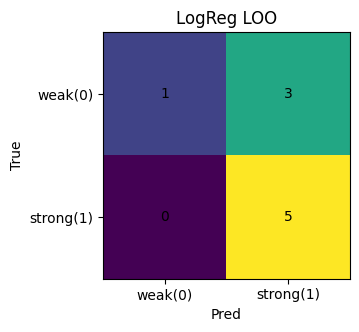

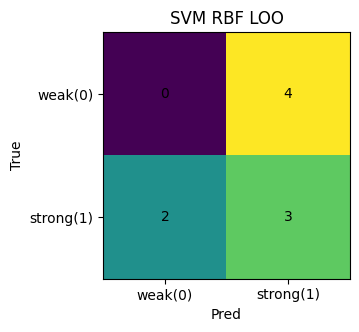

In [26]:

def plot_confusion(cm, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(3.5,3.2))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['weak(0)','strong(1)']); ax.set_yticklabels(['weak(0)','strong(1)'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i,j], ha="center", va="center")
    ax.set_xlabel("Pred"); ax.set_ylabel("True")
    plt.show()

plot_confusion(cm_log, "LogReg LOO")
plot_confusion(cm_svm, "SVM RBF LOO")



## 6) (Opcional) Persistência S3


In [ ]:

S3_BUCKET = None  # ex.: "meu-bucket-braket"
S3_PREFIX = "experimentos/poc_qkernel"



## 7) QPU real (instruções)
- Liste e selecione um QPU disponível na sua conta/região (Rigetti, IonQ, OQC, QuEra etc.).
- Ajuste `shots` (>= 4000) e considere mitigação de erro de leitura.



## 8) Critérios de sucesso para a demo
- Baselines clássicos com acurácia LOO > 0.6.
- Quantum kernel (SV1 ideal) ~ baseline ou melhor.
- Em DM1/QPU, acurácia > 0.6–0.7 com melhora ao aumentar shots/mitigação.
